In [1]:
!pip install hvplot

     |████████████████████████████████| 3.1 MB 21.2 MB/s 


In [10]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 34.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=463c214cb471c65afeb1d2129265ece60e6ca4c9e2488d8cf4be0e8260cc414e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [13]:
import numpy as np
import pandas as pd
import hvplot.pandas
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [14]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [15]:
BTC = yf.download('BTC-USD',start='2016-01-01')['Close']

[*********************100%***********************]  1 of 1 completed


In [16]:
gold = yf.download('GC=F',start='2016-01-01')["Close"]

[*********************100%***********************]  1 of 1 completed


In [21]:
gold = pd.DataFrame.from_dict(gold)
#Keep only the close column
gold = gold[['Close']]
#Rename the column name to gold
gold.columns = ['gold']
gold

,gold
Date,
2016-01-04,1075.099976
2016-01-05,1078.400024
2016-01-06,1091.900024
2016-01-07,1107.699951
2016-01-08,1097.800049
...,...
2021-10-12,1758.300049
2021-10-13,1793.699951
2021-10-14,1796.699951


In [24]:
df = BTC.merge(gold, how='inner',right_index = True, left_index=True)

In [25]:
df

,BTC,gold
Date,,
2016-01-04,433.091003,1075.099976
2016-01-05,431.959991,1078.400024
2016-01-06,429.105011,1091.900024
2016-01-07,458.048004,1107.699951
2016-01-08,453.230011,1097.800049
...,...,...
2021-10-12,56041.058594,1758.300049
2021-10-13,57401.097656,1793.699951
2021-10-14,57321.523438,1796.699951


In [26]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [27]:
window_size = 10

In [29]:
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [30]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [31]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [32]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [34]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 9
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [35]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [36]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 9)             396       
_________________________________________________________________
dropout (Dropout)            (None, 10, 9)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 9)             684       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 9)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 9)                 684       
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [37]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=10, verbose=1)

Epoch 1/10
101/101 [==============================] - 7s 14ms/step - loss: 0.0070
Epoch 2/10
101/101 [==============================] - 1s 15ms/step - loss: 0.0060
Epoch 3/10
101/101 [==============================] - 1s 15ms/step - loss: 0.0058
Epoch 4/10
101/101 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 5/10
101/101 [==============================] - 2s 15ms/step - loss: 0.0031
Epoch 6/10
101/101 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 7/10
101/101 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 8/10
101/101 [==============================] - 2s 15ms/step - loss: 0.0018
Epoch 9/10
101/101 [==============================] - 1s 15ms/step - loss: 0.0017
Epoch 10/10
101/101 [==============================] - 1s 15ms/step - loss: 0.0017


In [38]:
# Evaluate the model
model.evaluate(X_test, y_test)

14/14 [==============================] - 1s 5ms/step - loss: 0.0213


0.02125515230000019

In [39]:
# Make some predictions
predicted = model.predict(X_test)

In [40]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [41]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-01-28,1576.800049,1536.915527
2020-01-29,1569.199951,1537.519287
2020-01-30,1569.800049,1539.225830
2020-01-31,1583.500000,1541.616089
2020-02-03,1582.900024,1543.444336


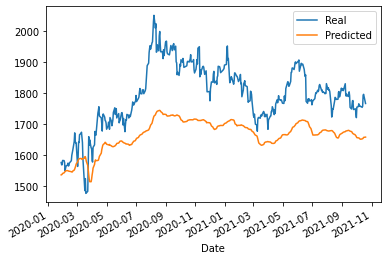

In [42]:
# Plot the real vs predicted values as a line chart
stocks.plot()